Example place fields from each group + no rotation place field correlation analysis

In [28]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg
import scipy.stats as sstats

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
from helpers import flatten

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Top rows: 8 fields from learner before shock and after shock. Top row = raw behavior with red dots, next row = PFs, next row = after PFS, bottom row = raw after behavior with red dots. Left 4 = Open, Right 4 = Shock

Next rows: Non-learner, same as above

Bottom rows: ANI, same as above

Very bottom - PF analysis with no rotation

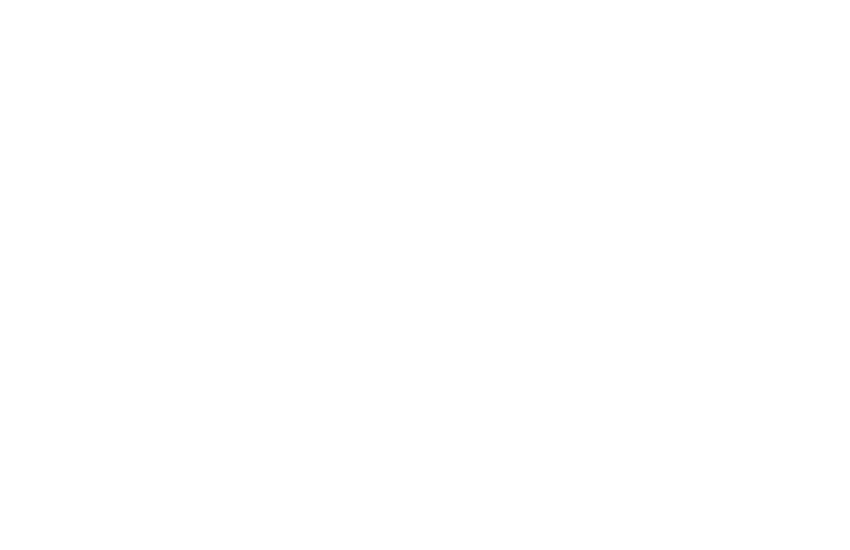

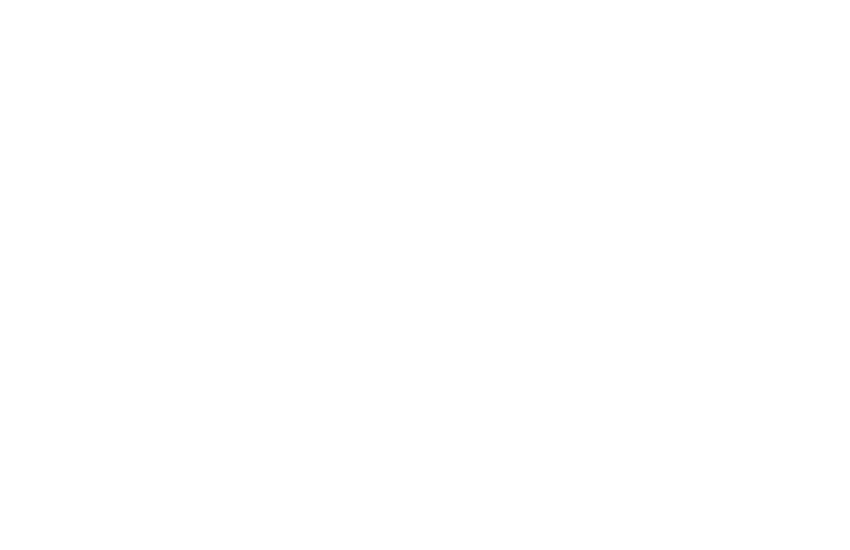

In [18]:
%matplotlib ipympl
FigS3nrot = Fig(num="S3", grid=(4, 5), size=(8.5, 5.5), fontsize=6)
FigS3nrot_stats = Fig(num="S3 no rotation", grid=(4, 5), size=(8.5, 5.5), fontsize=6)
FigS3nrot_comb = FigMirror(FigS3nrot, FigS3nrot_stats)

Define a bunch of notebook specific functions

In [3]:
def assemble_mean_corrs_all(corr_type: str in ['PF', 'PV1dboth', 'PV1all'], best_rot: bool, group_desig: int in [1, 2],
                       plot=False, nshuf=0):
    """Assemble pre-run MEAN place-field or MEAN population-vector correlations.
    :param corr_type: 2d PFs, 1d pv including only cells active in both sessions or all sessions
    :param best_rot: only applies to 2d PFs. True = rotate map to best rotation
    :param group_desig: 1 = include day 7 in "After" comparisons, 2 = only include days 1-2 (before more extinction happens)
    """
    # Need to run this to set up plots - I'm sure there is a better way...one option is to write code to assemble
    # these values for each day-pair independently...
    amice = err.ani_mice_good
    lmice = err.learners
    nlmice = err.nonlearners
    days = [-2, -1, 4, 1, 2, 7]

    learn_bestcorr_mean_all = []
    nlearn_bestcorr_mean_all = []
    ani_bestcorr_mean_all = []
    
    l_shuf_all, nl_shuf_all, ani_shuf_all = [], [], []

    if plot:
        figc, axc = plt.subplots(1,2)
        figc.set_size_inches((8.5, 3.5))
        
    for ida, arena in enumerate(['Open', 'Shock']):
        arena1 = arena
        arena2 = arena
        if corr_type == 'PF':
            _, templ, _, templ_shuf = pfs.get_group_pf_corrs(lmice, arena1, arena2, days, best_rot=best_rot, 
                                                             print_to_screen=False, nshuf=nshuf)
            _, tempnl, _, tempnl_shuf = pfs.get_group_pf_corrs(nlmice, arena1, arena2, days, best_rot=best_rot, 
                                                               print_to_screen=False, nshuf=nshuf)
            _, tempa, _, tempa_shuf = pfs.get_group_pf_corrs(amice, arena1, arena2, days, best_rot=best_rot, 
                                                             print_to_screen=False, nshuf=nshuf)
            prefix = 'PFcorrs'
        elif corr_type == 'PV1dboth':
            _, templ, _, templ_shuf = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False,
                                                               nshuf=nshuf)
            _, tempnl, _, tempnl_shuf = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False,
                                                                 nshuf=nshuf)
            _, tempa, _, tempa_shuf = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            prefix = 'PV1dcorrs_both'
        elif corr_type == 'PV1dall':
            templ, _, templ_shuf, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            tempnl, _, tempnl_shuf, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False, 
                                                                 nshuf=nshuf)
            tempa, _, tempa_shuf, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            prefix = 'PV1dcorrs_all'

        learn_bestcorr_mean_all.append(templ)
        nlearn_bestcorr_mean_all.append(tempnl)
        ani_bestcorr_mean_all.append(tempa)
        
        l_shuf_all.append(templ_shuf)
        nl_shuf_all.append(tempnl_shuf)
        ani_shuf_all.append(tempa_shuf)

        #  Combined scatterplots
        if plot:
            pfs.plot_pfcorr_bygroup(learn_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix, ax_use=axc[ida],
                                                color='k', offset=0, save_fig=False, group_desig=group_desig)
            pfs.plot_pfcorr_bygroup(ani_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
                                    color='g', offset=0.1, ax_use=axc[ida], group_desig=group_desig, save_fig=False)
            pfs.plot_pfcorr_bygroup(nlearn_bestcorr_mean_all[ida], arena1, arena2,
                                    prefix + ' ' + arena1 + 'v' + arena2 + ' Combined (k=learn, b=n-learn, g=Ani) best_rot=' + 
                                    str(best_rot), prefix=prefix, color='b', offset=0.1, ax_use=axc[ida], 
                                    group_desig=group_desig, save_fig=True, best_rot=best_rot)
        
    if nshuf == 0:
        return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all
    else:
        return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, l_shuf_all, nl_shuf_all, ani_shuf_all


In [4]:
def mean_corrs_to_df(learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, group_desig):
    """Dump output of above function into dataframe"""
    # Assemble mean correlations
    lgroups, group_labels = pfs.get_time_epochs(len(err.learners), group_desig)
    agroups, _ = pfs.get_time_epochs(len(err.ani_mice_good), group_desig)
    nlgroups, _ = pfs.get_time_epochs(len(err.nonlearners), group_desig)
    corrs_all, grp_all, arena_all, comp_type, subject_id = [], [], [], [], []
    for idg, (group, grp_label) in enumerate(zip(np.unique(lgroups[~np.isnan(lgroups)]).tolist(), group_labels)):
        open_corrs1 = learn_bestcorr_mean_all[0][lgroups == group]
        shock_corrs1 = learn_bestcorr_mean_all[1][lgroups == group]
        open_corrs2 = ani_bestcorr_mean_all[0][agroups == group]
        shock_corrs2 = ani_bestcorr_mean_all[1][agroups == group]
        open_corrs3 = nlearn_bestcorr_mean_all[0][nlgroups == group]
        shock_corrs3 = nlearn_bestcorr_mean_all[1][nlgroups == group]

        # Assemble data-frame!!!
        sid_prefix = 0
        for open_corr, shock_corr, grp in zip([open_corrs1, open_corrs2, open_corrs3], 
                                              [shock_corrs1, shock_corrs2, shock_corrs3], 
                                              ['Learners', 'ANI', 'Non-Learners']):
            corrs_all.extend(open_corr)
            grp_all.extend([grp]*len(open_corr))
            arena_all.extend(['Neutral']*len(open_corr))

            corrs_all.extend(shock_corr)
            grp_all.extend([grp]*len(shock_corr))
            arena_all.extend(['Shock']*len(shock_corr))

            comp_type.extend([grp_label]*(len(shock_corr) + len(open_corr)))

            if len(open_corr) != len(shock_corr):
                print('Mismatch in group ' + grp + ' ' + grp_label)
            elif len(open_corr) == len(shock_corr):
                subject_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for open field corrs
                subject_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for shock arena corrs
                sid_prefix += 100

    corr_df = pd.DataFrame({'corr': corrs_all, 'arena': arena_all, 'group': grp_all, 'comp_type': comp_type, 
                           'subject': subject_id})
    
    return corr_df

In [5]:
def pfplot_compare2(corr_df, comp_plot, ax, alpha=0.5, within_first=False, ax_lims=[0, 0.6], dotsize=3,
                   anova_type: str in ['normal', 'mixed'] = 'mixed', legend_keep=False, **kwargs):
    """Plotting function to overlay pf correlation stripplot with boxplot.
    **kwargs send to plt.text()"""
    boxprops = dict(alpha=alpha)
    
    # Plot data and label
    sns.stripplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
    sns.boxplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
    if not legend_keep:
        ax[0].get_legend().remove()
    ax[0].set_ylim(ax_lims)
    ax[0].set_xlabel('Arena')
    ax[0].set_ylabel('Mean PF Corr.')
    ax[0].set_title(comp_plot)
    
    # Now run stats: 2-way or mixed anova and post-hoc test
    aov = pg.anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', between=['arena', 'group']).round(5)
    maov = pg.mixed_anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', 
                          within='arena', between='group', subject='subject').round(3)
    if anova_type == 'normal':
        ax[1].text(0.05, 0.8, aov.to_string(index=False), **kwargs)
    elif anova_type == 'mixed':
        ax[1].text(0.05, 0.8, maov.to_string(index=False), **kwargs)  
            
    pw = pg.pairwise_tests(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', within_first=within_first,
                          within='arena', between='group', subject='subject', padjust='bonf').round(3)
    pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
    ax[1].text(0.05, 0.05, pwtrim.to_string(index=False), **kwargs)

In [6]:
def get_CI_mean(group, arena, comparison, group_desig):
    """Gets mean CIs for 2d PF correlations only"""
    # Get shuffled mean correlations
    shuf_CI_all = []
    for mouse in group:
        shuf_CI_temp = pfs.get_all_CIshuf(mouse, arena, arena, print_to_screen=False)
        shuf_CI_all.append(shuf_CI_temp)
    shuf_CI_all = np.stack(shuf_CI_all, axis=0)

    # Grab appropriate session-pair(s)
    nmice = len(group)
    group_mat, group_labels = pfs.get_time_epochs(nmice, group_desig)
    comp_id = np.where([label == comparison for label in group_labels])[0] + 1
    keep_bool = group_mat[0] == comp_id

    comp_shuf_CI = shuf_CI_all[:, :, keep_bool].squeeze()
    
    return comp_shuf_CI

In [7]:
def add_shuf_CI(ax, comparison, group_desig):
    """Add confidence intervals (95%) from shuffled data to plots for mean correlation value - for PF2d only"""
    groups = [err.learners, err.ani_mice_good, err.nonlearners]
    x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True
    
    for ida, arena in enumerate(['Neutral', 'Shock']):
        # Get CIs
        CI_comb = []
        for group in groups:
            comp_shuf_CI = get_CI_mean(group, 'Open' if arena == 'Neutral' else arena, 
                                       comparison, group_desig)  # Get shuffled CI for all mice in group
            if comp_shuf_CI.ndim == 3:  # Reshape if more than one set of day-pairs in comparison
                comp_shuf_CI = comp_shuf_CI.swapaxes(0,1).reshape(3,-1).T
            CI_comb.append(np.nanmean(comp_shuf_CI, axis=0))  # Average it, add it into grou
        CI_plot = np.stack(CI_comb)  # make into array
        
        # Add to plot
        hl = ax.plot(x_offset + ida, CI_plot, linestyle='--', color=[0, 0, 0, 0.5])
        hl[1].set_linestyle('-')

Now plot pfs at no rotation

In [19]:
# Assemble dataframe
group_desig = 2  # 1 = include days 1,2, AND 7 in after shock group, 2 = include days 1 and 2 only
learn_corr_all, nl_corr_all, ani_corr_all = assemble_mean_corrs_all(corr_type='PF', best_rot=False, 
                                                                    group_desig=group_desig, plot=False)
corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

# Set up plots for Fig2 and FigS4
ax_bef_comb = FigS3nrot_comb.subplot([FigS3nrot.gs[0, 0], FigS3nrot_stats.gs[0, 0]])
ax_aft_comb = FigS3nrot_comb.subplot([FigS3nrot.gs[0, 1], FigS3nrot_stats.gs[0, 1]])
ax_ba_comb = FigS3nrot_comb.subplot([FigS3nrot.gs[0, 2], FigS3nrot_stats.gs[0, 2]])
ax_bstm_comb = FigS3nrot_comb.subplot(454)
ax_stma_comb = FigS3nrot_comb.subplot(455)

# Set up plotting params
ax_lims = [-0.1, 0.6]
anova_type = 'mixed'
within_first = True

# Now make the plots
for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
                        corr_df['comp_type'].unique()):
    legend_keep = True if comp_type in ['Before', 'Before v STM'] else False
    pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
                   legend_keep=legend_keep, fontdict={"size": 3})
    add_shuf_CI(a[0], comp_type, group_desig)

Missing pf files for Marble06 Open Day -2 to Open Day 7
Missing pf files for Marble06 Open Day -1 to Open Day 7
Missing pf files for Marble06 Open Day 4 to Open Day 7
Missing pf files for Marble06 Open Day 1 to Open Day 7
Missing pf files for Marble06 Open Day 2 to Open Day 7
Missing pf files for Marble06 Shock Day -2 to Shock Day 7
Missing pf files for Marble06 Shock Day -1 to Shock Day 7
Missing pf files for Marble06 Shock Day 4 to Shock Day 7
Missing pf files for Marble06 Shock Day 1 to Shock Day 7
Missing pf files for Marble06 Shock Day 2 to Shock Day 7


Now plot ecdfs

In [20]:
# Define axes to plot into

gs_corr_subfig = FigS3nrot.subplot2grid(subplot_spec=FigS3nrot.gs[1, 0], grid=(1, 2))
ax_all_bef_comb = [[FigS3nrot.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrot_stats.subplot(456)]
gs_corr_subfig = FigS3nrot.subplot2grid(subplot_spec=FigS3nrot.gs[1, 1], grid=(1, 2))
ax_all_aft_comb = [[FigS3nrot.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrot_stats.subplot(457)]
gs_corr_subfig = FigS3nrot.subplot2grid(subplot_spec=FigS3nrot.gs[1, 2], grid=(1, 2))
ax_all_ba_comb = [[FigS3nrot.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrot_stats.subplot(458)]

gs_corr_subfig = FigS3nrot.subplot2grid(subplot_spec=FigS3nrot.gs[1, 3], grid=(1, 2))
ax_all_bstm_comb = [[FigS3nrot.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrot_stats.subplot(459)]
gs_corr_subfig = FigS3nrot.subplot2grid(subplot_spec=FigS3nrot.gs[1, 4], grid=(1, 2))
ax_all_stma_comb = [[FigS3nrot.fig.add_subplot(gs) for gs in gs_corr_subfig], 
                    FigS3nrot_stats.subplot(FigS3nrot_stats.gs[1, 4])]

ax_allpf_comb = [ax_all_bef_comb, ax_all_aft_comb, ax_all_ba_comb, ax_all_bstm_comb, ax_all_stma_comb]

In [23]:
FigS3nrinset = Fig(num="Figure 3nr Inset", grid=(2, 3), size=(6.5, 2*2 ), fontsize=6)
FigS3nrinset_stats = Fig(num="Figure 3nr Inset stats", grid=(2, 3), size=(8.5, 2.5*3 ), fontsize=6)
FigS3nrinsetcomb = FigMirror(FigS3nrinset, FigS3nrinset_stats)

gs_corr_subfig = FigS3nrinset.subplot2grid(subplot_spec=FigS3nrinset.gs[0, 0], grid=(1, 2))
ax_all_bef_comb_i = [[FigS3nrinset.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrinset_stats.subplot(231)]
gs_corr_subfig = FigS3nrinset.subplot2grid(subplot_spec=FigS3nrinset.gs[0, 1], grid=(1, 2))
ax_all_aft_comb_i = [[FigS3nrinset.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrinset_stats.subplot(232)]
gs_corr_subfig = FigS3nrinset.subplot2grid(subplot_spec=FigS3nrinset.gs[0, 2], grid=(1, 2))
ax_all_ba_comb_i = [[FigS3nrinset.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrinset_stats.subplot(232)]

gs_corr_subfig = FigS3nrinset.subplot2grid(subplot_spec=FigS3nrinset.gs[1, 0], grid=(1, 2))
ax_all_bstm_comb_i = [[FigS3nrinset.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrinset_stats.subplot(233)]
gs_corr_subfig = FigS3nrinset.subplot2grid(subplot_spec=FigS3nrinset.gs[1, 1], grid=(1, 2))
ax_all_stma_comb_i = [[FigS3nrinset.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS3nrinset_stats.subplot(234)]

ax_allpf_comb_i = [ax_all_bef_comb_i, ax_all_aft_comb_i, ax_all_ba_comb_i, ax_all_bstm_comb_i, ax_all_stma_comb_i]

In [24]:
# Function here to add in stats to ecdf group
def add_ks_stats_to_ecdf(group_corrs, ax_use, ytext_start=0.8, bonf_corr=3, **kwargs):
    id1, id2 = [0, 0, 1], [1, 2, 2]
    group_names = ['Learners', 'Non-Learners', 'ANI']
    y = ytext_start
    for i1, i2 in zip(id1, id2):
        kstat, pval = sstats.ks_2samp(group_corrs[i1], group_corrs[i2])
        ax_use.text(0.1, y, f'{group_names[i1]} v {group_names[i2]}: pval={pval*bonf_corr:0.3g}, kstat={kstat:0.3g}',
                   **kwargs)
        y -= 0.1

In [29]:
# Assemble and plot ecdfs
groups = [err.learners, err.nonlearners, err.ani_mice_good]
group_names = ['Learners', 'Non-Learners', 'ANI']
days = np.array([-2, -1, 4, 1, 2, 7])
best_rot = False
bonferroni_correction = 3 # multiply by this for bonferroni correction for multiple comparisons

epochs, group_labels = pfs.get_time_epochs(2, group_desig=group_desig)

rot_append = ': Best Rotation' if best_rot else ''
all_corrs = []
for ax, axin, comp in zip(ax_allpf_comb, ax_allpf_comb_i, group_labels):
    ax[0][0].set_title(comp + rot_append)
    comp_id = np.where([comp == group for group in group_labels])[0][0] + 1
    arena_corrs = []
    for ida, (a, ain, arena) in enumerate(zip(ax[0], axin[0], ['Open', 'Shock'])):

        # Aggregate corrs for arena
        days1, days2 = [days[id] for id in np.where(epochs[0] == comp_id)]
        group_corrs = []
        for group in groups:
            mouse_corrs = []
            for mouse in group:
                for day1, day2 in zip(days1, days2):
                    # Rotate pf maps to best rotation if specified
                    if best_rot:
                        _, rot_use, _ = pfs.get_best_rot(mouse, arena, int(day1), arena, int(day2), 
                                                         batch_map_use=True, print_to_screen=False)
                        rot = rot_use[1]
                    else:
                        rot = 0
                    _, corrs_sm = pfs.pf_corr_bw_sesh(mouse, arena, int(day1), arena, int(day2), batch_map_use=True,
                                                     rot_deg=rot)
                mouse_corrs.extend(corrs_sm)
            group_corrs.append(mouse_corrs)

        # Plot for arena
        line_types = ['-', '--', ':']
        for idc, corrs in enumerate(group_corrs):
            sns.ecdfplot(data=corrs, ax=a, color=plt.get_cmap("Set2").colors[idc], linewidth=0.5, 
                         linestyle=line_types[idc])

        if arena == 'Open':
            a.legend(a.lines, ['Learners', 'Non-Learners', 'ANI'])
            arena_str = 'Neutral'
        elif arena == 'Shock':
            arena_str = 'Shock'
        a.set_title(arena_str)
        a.set_xlabel('PF corrs')
        
        # Stats
        ax[1].text(0.1, 1.0, comp)
        ystatloc = 0.9 if arena == 'Open' else 0.4
#         print(str(ystatloc))
        ax[1].text(0.1, ystatloc, f'{arena_str}: pvals w/bonf corr={bonferroni_correction}')
        add_ks_stats_to_ecdf(group_corrs, ax[1], 0.8 - (0.4 * ida), bonf_corr=bonferroni_correction,
                             fontdict={"size": 3})
        arena_corrs.append(group_corrs)
        
        # Plot out inset bar plots
        dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
                              'Group' : list(flatten([[group_name]*len(group_corr) for 
                                                      group_corr, group_name in zip(group_corrs, group_names)]))})
        sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ain, errwidth=1.0, palette='Set2')
        ain.set_title(f'{arena_str}: {comp}')
        astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc + 0.1, f'{arena_str}: {comp}')
        axin[1].text(0.1, ystatloc, str(astats))
        tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc-0.3, str(tuk_stats))
        
        
    all_corrs.append(arena_corrs)


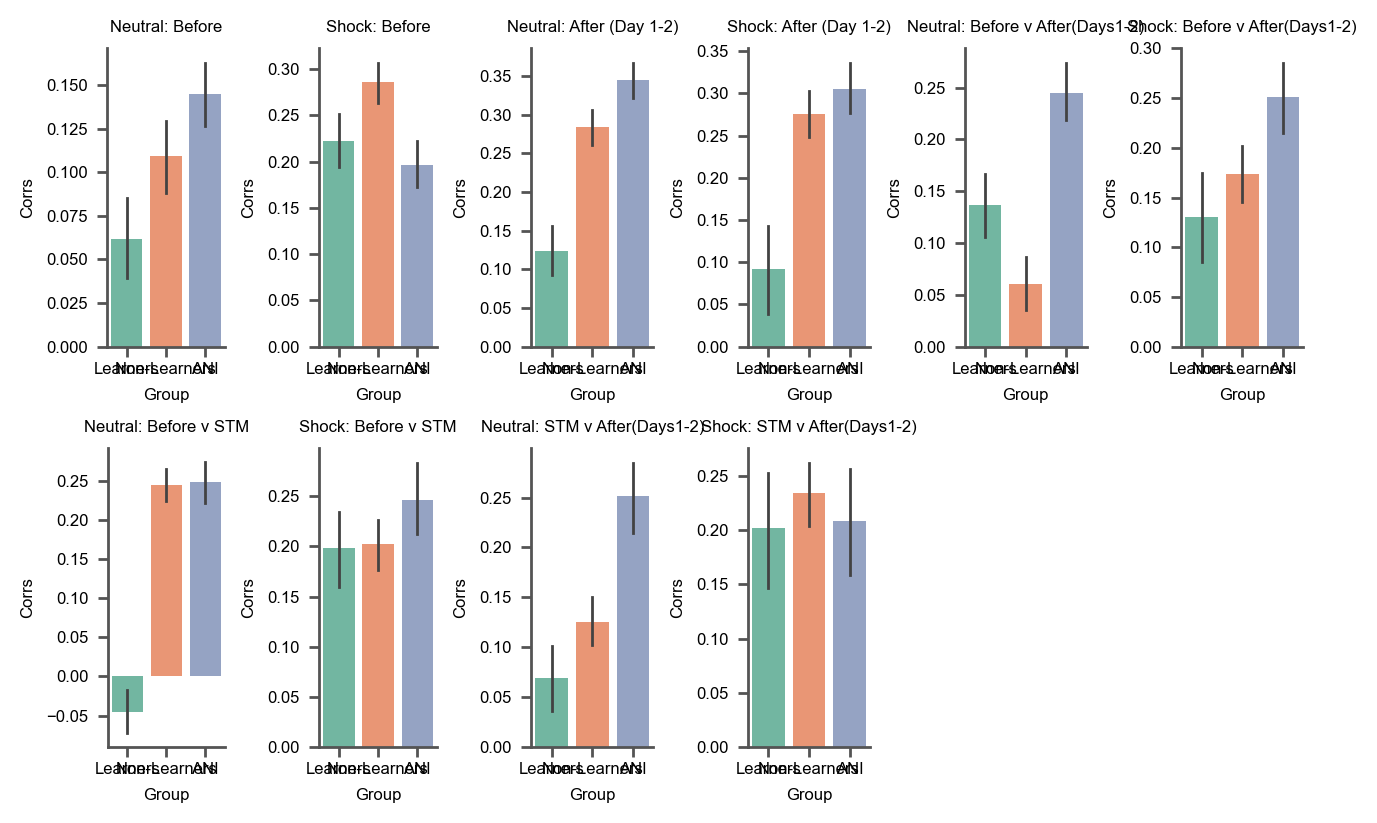

In [31]:
FigS3nrinset.fig

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


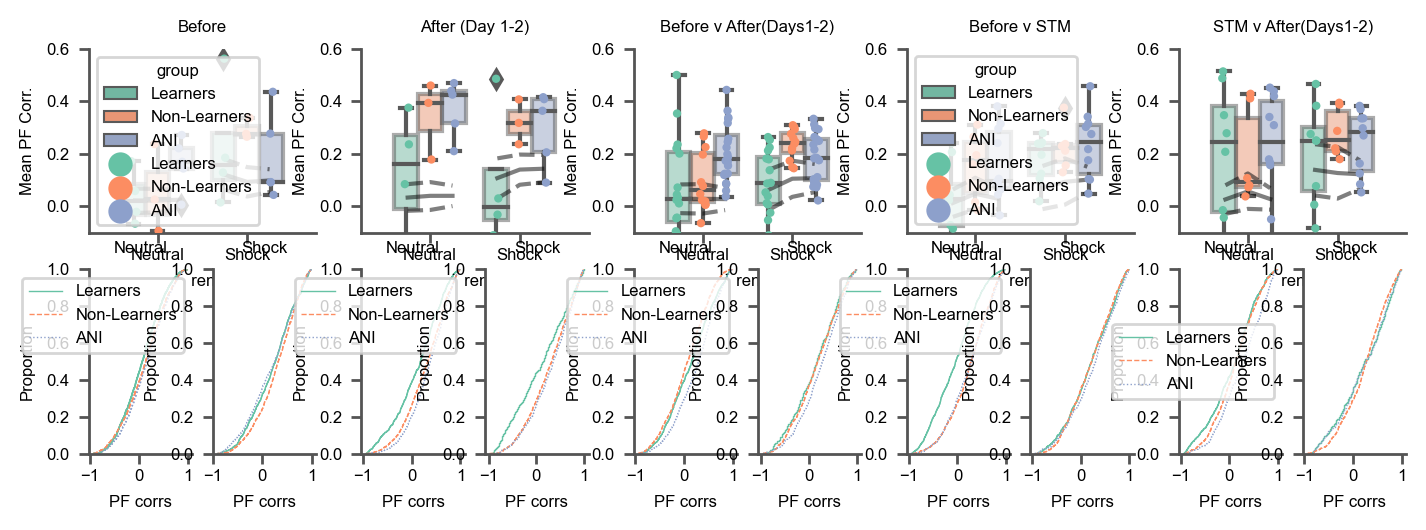

In [30]:
FigS3nrot.fig

In [33]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
for comb_fig_save, name in zip([FigS3nrot_comb, FigS3nrinsetcomb], ['FigureS3_no_rot', 'FigureS3_no_rot_inset']):
    comb_fig_save.Fig1.savefig(plot_path / (name + '.pdf'), scriptname = 'FigureS3.ipynb')
    comb_fig_save.Fig2.savefig(plot_path / (name + '_stats.pdf'), scriptname = 'FigureS3.ipynb')

/Users/nkinsky/Documents/BU/GitHub/Eraser/plotting.py:259: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(filename, dpi=dpi, backend="pdf")
